In [1]:
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import random
import numpy as np
from numpy import sin 
from numpy import cos
from math import acos
from math import atan
from math import radians
from math import sqrt

class Vehicle:
    
    def __init__(self, v = 500, x = 0, z = 0, y = 0, theta = 0, phi = 0):
        self.position = []
        self.v = v
        self.theta = theta
        self.phi = phi
        self.x = x
        self.z = z
        self.y = y
        self.r = sqrt(self.x**2 + self.z**2 + self.y**2)
        self.dx = self.dz = self.dy = 0
        self.position.append([self.x, self.z, self.y])
    
    def update(self, dv, dtheta, dphi, dt):
        self.v += dv
        self.r = self.v * dt
        self.theta += dtheta
        self.phi += dphi
        self.dx = self.r * cos(self.theta) * cos(self.phi)
        self.dz = self.r * cos(self.theta) * sin(self.phi)
        self.dy = self.r * sin(self.theta)   
        self.x += self.dx #if abs(self.dx) > (0.0001 * dt) else 0
        self.z += self.dz #if abs(self.dz) > (0.0001 * dt) else 0
        self.y += self.dy #if abs(self.dy) > (0.0001 * dt) else 0
        self.position.append([self.x, self.z, self.y])
        
class RungeKutta:
    def __init__(self, f, t0, y0, dt):
        self.f = f
        self.t0 = t0
        self.y0 = y0
        self.dt = dt
        
    def rungeKuttaSolve(self):
        k1 = self.dt * self.f(self.t0, self.y0)
        k2 = self.dt * self.f(self.t0 + 0.5 * self.dt, self.y0 + 0.5 * k1)
        k3 = self.dt * self.f(self.t0 + 0.5 * self.dt, self.y0 + 0.5 * k2)
        k4 = self.dt * self.f(self.t0 + self.dt, self.y0 + k3)
        y = (k1 + k2 + k2 + k3 + k3 + k4) / 6
        
        return y
        
    
def D_dotf(t, D):
    delta_D = target.v * cos(sigma[i-1]-target.phi) * cos(epsilon[i-1]-target.theta) - missile.v * cos(sigma[i-1]-missile.phi) * cos(epsilon[i-1]-missile.theta)
    return delta_D

def epsilon_dotf(t, epsilon_0):
    delta_epsilon = (missile.v * cos(sigma[i-1]-missile.phi) * sin(epsilon_0-missile.theta) - target.v * cos(sigma[i-1]-target.phi) * sin(epsilon_0-target.theta))/D[i-1]
    return delta_epsilon

def sigma_dotf(t, sigma_0):
    delta_sigma = (missile.v * sin(sigma_0-missile.phi) * cos(missile.theta) - target.v * sin(sigma_0-target.phi) * cos(target.theta))/(D[i-1]*cos(epsilon[i-1]))
    return delta_sigma

def epsilon0_sigma0(target, missile):
    AB = np.array(target.position) - np.array(missile.position)
    AB = AB[0]
    BC = np.array(target.position) - np.array(missile.position)
    BC[0][2] = 0
    BC = BC[0]
    CD = np.array(target.position) - np.array(missile.position)
    CD[0][1] = CD[0][2] = 0
    CD = CD[0]
    AB_mg = np.linalg.norm(AB)
    BC_mg = np.linalg.norm(BC)
    CD_mg = np.linalg.norm(CD)
    ABdotBC = np.dot(AB,BC)
    BCdotCD = np.dot(BC,CD)
    epsilon0 = acos(ABdotBC / (AB_mg * BC_mg))
    sigma0 = acos(BCdotCD / (CD_mg * BC_mg))
    return epsilon0, sigma0

Missile hit the target using  Porportional navigation  after  59.6  seconds


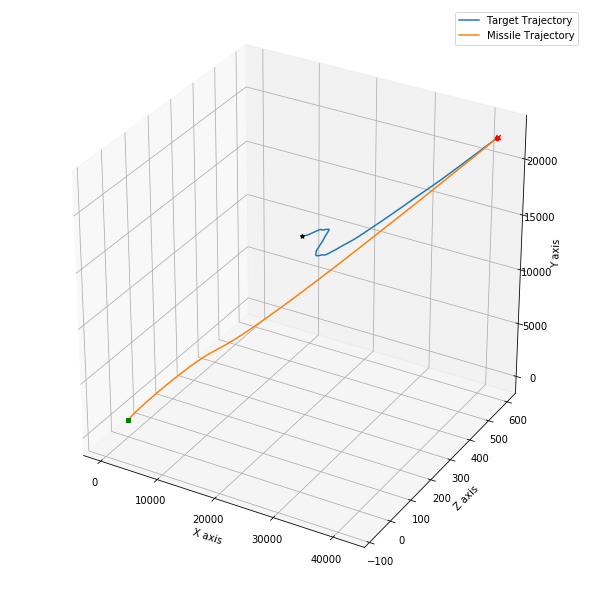

In [2]:
dt = 0.1
tf = 100
time = np.arange(0, tf, dt)     
target = Vehicle(v = 200, x = 37*1000*cos(radians(35)), z = 0, y = 37*1000*sin(radians(35)), theta = radians(0), phi = radians(0))
missile = Vehicle(v = 800, x = 0, z = 0, y = 0, theta = radians(0), phi = radians(0))

G = 2
Guidance_Laws = ["Pure pursuit", "Deviated pursuit", "Porportional navigation"]
Guidance_Law = Guidance_Laws[G]

D       = [None] * len(time)
epsilon = [None] * len(time)
thetam = [None] * len(time)
thetam[0] = 0
sigma   = [None] * len(time)


D[0] = target.r - missile.r

epsilon[0], sigma[0] = epsilon0_sigma0(target, missile)
missflag = 0
missile.theta = epsilon[0]
for i in range(1, len(time)):
    t0 = time[i-1]
    t1 = time[i]
    D0 = D[i-1]
    epsilon0 = epsilon[i-1]
    sigma0 = sigma[i-1]
    
    # Target moves
    maxdef = 5 * dt
    dtheta_t = radians(random.uniform(-maxdef, maxdef))
    dphi_t = radians(random.uniform(-maxdef, maxdef))
    target.update(0, dtheta_t, dphi_t, dt)
    
    # Missile observes
    D_d = target.v * cos(sigma[i-1]-target.phi) * cos(epsilon[i-1]-target.theta) - missile.v * cos(sigma[i-1]-missile.phi) * cos(epsilon[i-1]-missile.theta)
    epsilon_d = (missile.v * cos(sigma[i-1]-missile.phi) * sin(epsilon[i-1]-missile.theta) - target.v * cos(sigma[i-1]-target.phi) * sin(epsilon[i-1]-target.theta))/D[i-1]
    sigma_d = (missile.v * sin(sigma[i-1]-missile.phi) * cos(missile.theta) - target.v * sin(sigma[i-1]-target.phi) * cos(target.theta))/(D[i-1]*cos(epsilon[i-1]))
    
    # Missile updates its belief about target
    epsilon[i] = epsilon[i-1] + epsilon_d * dt
    sigma[i] = sigma[i-1] + sigma_d * dt
    D[i] = D[i-1] + D_d * dt
    if abs(D[i]) < 20:
        print("Missile hit the target using ", Guidance_Law," after ", time[i]," seconds")
        break
    elif D[i] > D[i-1]:
        missflag = missflag + 1
        if missflag == 2:
            print("Missile missed the target")
            
    thetaM_old = missile.theta
    phiM_old = missile.phi
    # Missile gives new commands
    if Guidance_Law == "Pure pursuit":
        thetaM_new = epsilon[i]
        phiM_new = sigma[i]
    elif Guidance_Law == "Deviated pursuit":
        epsilon_p = 5
        sigma_p = 5
        epsilon_p = radians(epsilon_p)
        sigma_p = radians(sigma_p)
        thetaM_new = epsilon[i] - epsilon_p
        phiM_new = sigma[i] - sigma_p
    elif Guidance_Law == "Porportional navigation":
        k1 = 4
        k2 = 4
        thetaM_new = thetaM_old + k1 * epsilon_d * dt
        phiM_new = phiM_old + k2 * sigma_d * dt
    
    # Missile Pursuits
    dtheta_m = thetaM_new - thetaM_old
    dphi_m = phiM_new - phiM_old
    missile.update(0, dtheta_m, dphi_m, dt)
    thetam[i] = missile.theta

fig = plt.figure(figsize=(8, 8))
ax = Axes3D(fig)
#ax.set_xlim3d(-5000, 80000)
#ax.set_ylim3d(-5000, 80000)
#ax.set_zlim3d(-5000, 80000)
ax.set_xlabel('X axis')
ax.set_zlabel('Y axis')
ax.set_ylabel('Z axis')

xt, zt, yt = zip(*target.position)
xm, zm, ym = zip(*missile.position)

ax.plot(xt, zt, yt, label='Target Trajectory')
ax.plot(xm, zm, ym, label='Missile Trajectory')
ax.scatter(xt[-1], zt[-1], yt[-1], c='r', marker='x')   # End point
ax.scatter(xt[0], zt[0], yt[0], c='k', marker='*')   # Start point
ax.scatter(xm[-1], zm[-1], ym[-1], c='r', marker='o')   # End point
ax.scatter(xm[0], zm[0], ym[0], c='g', marker='s')   # Start point
ax.legend()
#ax.view_init(70, 0)
plt.grid()
plt.show()

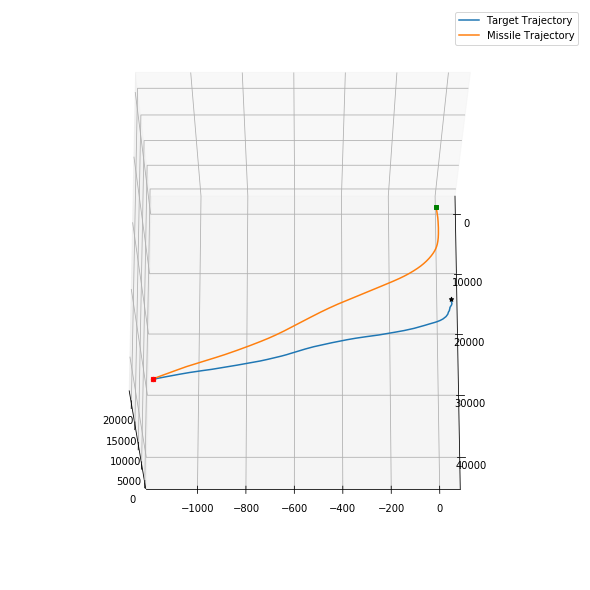

In [3]:
fig = plt.figure(figsize=(8, 8))
ax = Axes3D(fig)

ax.plot(xt, zt, yt, label='Target Trajectory')
ax.plot(xm, zm, ym, label='Missile Trajectory')
ax.scatter(xt[-1], zt[-1], yt[-1], c='r', marker='x')   # End point
ax.scatter(xt[0], zt[0], yt[0], c='k', marker='*')   # Start point
ax.scatter(xm[-1], zm[-1], ym[-1], c='r', marker='o')   # End point
ax.scatter(xm[0], zm[0], ym[0], c='g', marker='s')   # Start point
ax.legend()
ax.view_init(70, 0)
plt.grid()
plt.show()

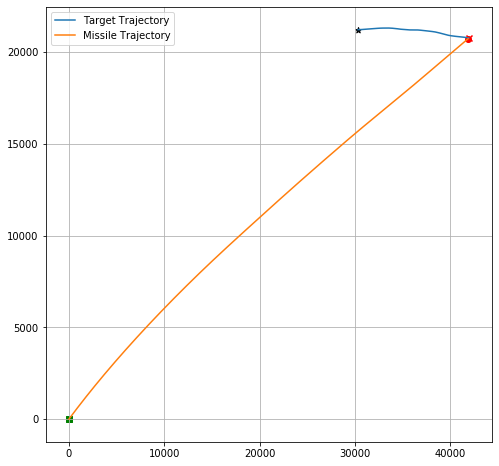

In [4]:
fig = plt.figure(figsize=(8, 8))

xt, z,yt = zip(*target.position)
xm, z,ym = zip(*missile.position)

plt.plot(xt, yt, label='Target Trajectory')
plt.plot(xm, ym, label='Missile Trajectory')
#print(zt)
plt.scatter(xt[-1], yt[-1], c='r', marker='x')   # End point
plt.scatter(xt[0], yt[0], c='k', marker='*')   # Start point
plt.scatter(xm[-1], ym[-1], c='r', marker='o')   # End point
plt.scatter(xm[0], ym[0], c='g', marker='s')   # Start point
plt.legend()
plt.grid()
#ax.view_init(70, 0)
plt.show()